In [1]:
import simcse
import torch
from transformers import AutoModel, AutoTokenizer, AutoConfig
from simcse.models import *
import numpy as np
from sklearn.manifold import TSNE
import collections
import pandas as pd
import matplotlib.pyplot as plt
from train import ModelArguments

In [2]:
class Similarity(nn.Module):
    """
    Dot product or cosine similarity
    temp = 0.05, from the paper
    """

    def __init__(self, temp):
        super().__init__()
        self.temp = temp
        self.cos = nn.CosineSimilarity(dim=-1)

    def forward(self, x, y):
        return self.cos(x, y) / self.temp


In [3]:
sim = Similarity(0.05)

In [4]:
def plot_scatter(emb, labels=None):
    '''
    emb: numpy array, tranformed by TSNE
    labels: list of string or int, if any
    '''
    if labels!=None:
        unique_labels = list(set(labels))
        for ul in unique_labels:
            idx = test_labels == ul
            plt.scatter(emb[idx,0], emb[idx,1], label = ul)
        plt.legend()
    else:
        plt.scatter(emb[:,0], emb[:,1])

In [5]:
def get_similar_pairs(cos_sim, threshold = 15, drop_duplicates = True):
    '''
    cos_sim: numpy array, pairwise similarity of embeddings
    threshold: int or float, between 0 and 20. keep most similar pairs by 
    drop_duplicates: boolern, e.g. (1,3) and (3,1), keep (1,3)
    
    output: numpy array of shape (n,2), the indeces of sentences that have high similarity
    '''
    idxx, idxy = np.where(cos_sim>15)
    idxxy = np.where(idxx!=idxy)
    similar_pairs = np.stack((idxx[idxxy], idxy[idxxy]), axis=0).T
    if drop_duplicates:
        keep_idx = []
        for i,pair in enumerate(similar_pairs):
            if pair[0]<pair[1]:
                keep_idx.append(i)
        similar_pairs = similar_pairs[keep_idx]
    return similar_pairs

In [6]:
def print_pair_sentences(similar_pairs, df, labels=None):
    '''
    similar_pairs: numpy array of shape (n,2), the indeces of sentences that have high similarity
    '''
    text = df['text'].tolist()
    if labels:
        for label in labels:
            exec(f"{label} = df['{label}'].tolist()")
    for pair in similar_pairs:
        print('#'*30)
        print(f"sent#{pair[0]}: {text[pair[0]]}", end='')
        if labels:
            for label in labels:
                print(f"\t{label}:{eval(f'{label}[pair[0]]')}", end='')
        print('')
        print(f"sent#{pair[1]}: {text[pair[1]]}", end='')
        if labels:
            for label in labels:
                print(f"\t{label}:{eval(f'{label}[pair[1]]')}", end='')
        print('')

In [7]:
model_name_or_path = './result/my-unsup-simcse-roberta-base-c_b_p-c_e_l-anneal_both-c0.5-e0.5/'
config = AutoConfig.from_pretrained(model_name_or_path)
model_args = ModelArguments(pooler_type='cls_before_pooler')
model = RobertaForCL.from_pretrained(model_name_or_path, model_args=model_args)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

Visualize the style embeddings and the sentence embeddings that my model generates. See if they form clusters.

On different datasets.

# Training set

In [13]:
df = pd.read_csv('data/wiki1m_with_pos.csv', index_col=False)
test_sentences = df['text'].iloc[:100].tolist()
batch_tensors = tokenizer(test_sentences,return_tensors='pt', padding=True, truncation=True, max_length=32)
model_outputs = model(**batch_tensors, sent_emb=True, return_dict=True)

sent_emb = model_outputs['pooler_output'].detach().numpy()
sent_emb = sent_emb.astype('float64')
style_emb = model_outputs['style_emb'].detach().numpy()
style_emb = style_emb.astype('float64')

In [14]:
sent_emb_transformed = TSNE(n_components=2, init='random').fit_transform(sent_emb)
style_emb_transformed = TSNE(n_components=2, init='random').fit_transform(style_emb)

## embedding tsne

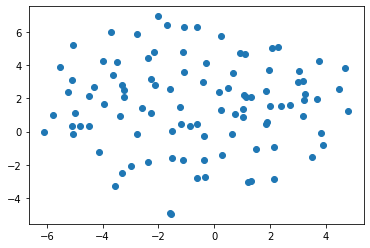

In [15]:
plot_scatter(style_emb_transformed)

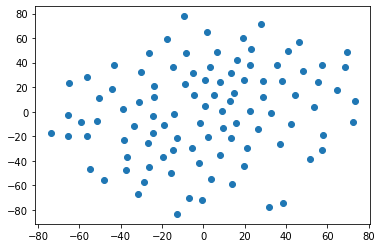

In [16]:
plot_scatter(sent_emb_transformed)

## similarity heatmap

In [20]:
def plot_heatmap(cos_sim, clip = False):
    if clip:
        plt.imshow(cos_sim.numpy(), vmin = 0, vmax = 20)
    else:
        plt.imshow(cos_sim.numpy())
    plt.colorbar()
    plt.show()

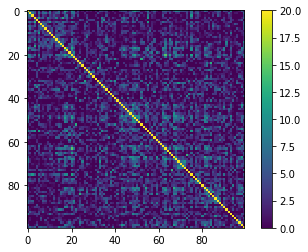

In [21]:
cos_sim_style = sim(torch.from_numpy(style_emb).unsqueeze(1), torch.from_numpy(style_emb).unsqueeze(0))
plot_heatmap(cos_sim_style, clip=True)

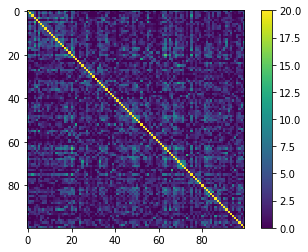

In [22]:
cos_sim_sent= sim(torch.from_numpy(sent_emb).unsqueeze(1), torch.from_numpy(sent_emb).unsqueeze(0))
plot_heatmap(cos_sim_sent, clip=True)

# other datasets

In [40]:
# df = pd.read_csv('style_datasets/CrowdFlower/train.tsv', delimiter='\t', names=['num','label', 'text'], index_col=False)
# df = pd.read_csv('style_datasets/DailyDialog/train.tsv', delimiter='\t', names=['text','label'], index_col=False)

# for emobank, The columns V, A and D represent Valence (negative vs. positive), Arousal (calm vs. excited), and Dominance (being controlled vs. being in control). 
df = pd.read_csv('style_datasets/EmoBank/train.tsv', delimiter='\t', names=['id','V','A','D','text'], index_col=False)

In [44]:
df.head(10)

,id,V,A,D,text
0,110CYL068_1036_1079,3.00,3.00,3.20,"Remember what she said in my last letter? """
1,110CYL068_1079_1110,2.80,3.10,2.80,If I wasn't working here.
2,110CYL068_1127_1130,3.00,3.00,3.00,".."""
3,110CYL068_1137_1188,3.44,3.00,3.22,Goodwill helps people get off of public assist...
4,110CYL068_1475_1558,3.60,3.30,3.80,Coming to Goodwill was the first step toward m...
5,110CYL068_1559_1601,3.00,3.00,3.10,"I am now... totally off of welfare."""
6,110CYL068_1608_1658,3.10,3.10,3.10,Goodwill prepares people for life-long employm...
7,110CYL068_163_275,3.25,2.88,3.00,Here's another story of success from what migh...
8,110CYL068_1659_1810,3.25,3.00,3.25,Cornell found a number of employment options t...
9,110CYL068_1811_1946,3.25,2.88,3.12,He trained in desktop publishing and combined ...


In [45]:
test_sentences = df['text'].iloc[:100].tolist()
# test_labels = df['label'].iloc[:100].tolist()

In [46]:
batch_tensors = tokenizer(test_sentences,return_tensors='pt', padding=True, truncation=True, max_length=32)
model_outputs = model(**batch_tensors, sent_emb=True, return_dict=True)

In [47]:
sent_emb = model_outputs['pooler_output'].detach().numpy()
sent_emb.astype('float64')
style_emb = model_outputs['style_emb'].detach().numpy()
style_emb.dtype = 'float64'

In [48]:
sent_emb_transformed = TSNE(n_components=2, n_iter = 2000, init='random').fit_transform(sent_emb)
style_emb_transformed = TSNE(n_components=2, n_iter = 2000, init='random').fit_transform(style_emb)

# embedding tsne 

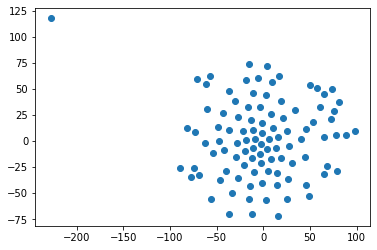

In [49]:
# style_emb
plot_scatter(style_emb_transformed)

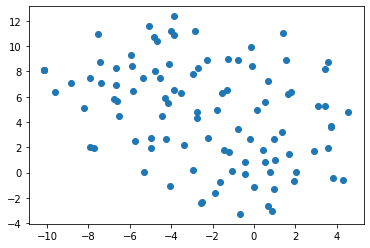

In [51]:
# sent_emb
plot_scatter(sent_emb_transformed)

## similarity heatmap

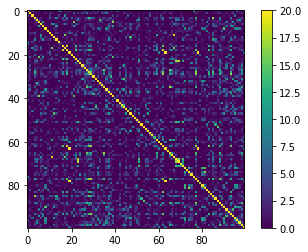

In [52]:
# style_emb
cos_sim_style = sim(torch.from_numpy(style_emb).unsqueeze(1), torch.from_numpy(style_emb).unsqueeze(0))
plot_heatmap(cos_sim_style,clip=True)

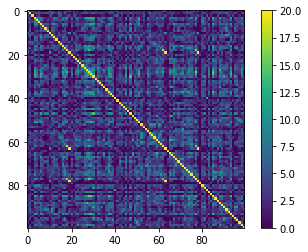

In [53]:
# sent_emb
cos_sim_sent = sim(torch.from_numpy(sent_emb).unsqueeze(1), torch.from_numpy(sent_emb).unsqueeze(0))
plot_heatmap(cos_sim_sent,clip=True)

## check high similarity sentence pairs

In [54]:
# style_emb
similar_style_pairs = get_similar_pairs(cos_sim_style, threshold=15)
print('similar_style_pairs')
print_pair_sentences(similar_style_pairs, df, ['V','A','D'])

similar_style_pairs
##############################
sent#3: Goodwill helps people get off of public assistance.	V:3.44	A:3.0	D:3.22
sent#85: You have helped make Goodwill's work possible with your previous support.	V:3.6	A:2.9	D:3.1
##############################
sent#5: I am now... totally off of welfare."	V:3.0	A:3.0	D:3.1
sent#21: P.S.	V:3.0	A:2.43	D:3.0
##############################
sent#5: I am now... totally off of welfare."	V:3.0	A:3.0	D:3.1
sent#39: You can earn the money to support yourself and your family, she says.	V:3.0	A:2.86	D:3.29
##############################
sent#11: I've got more than a job; I've got a career."	V:3.27	A:3.36	D:3.36
sent#17: Your support will help them go to work.	V:3.7	A:3.4	D:3.3
##############################
sent#11: I've got more than a job; I've got a career."	V:3.27	A:3.36	D:3.36
sent#67: The gift that I am asking you to make will be used to continue our mission of helping people prepare for, find and keep jobs.	V:3.2	A:3.0	D:2.9
##############

In [55]:
# sent_emb
similar_sent_pairs = get_similar_pairs(cos_sim_sent, threshold=15)
print('similar_sent_pairs')
print_pair_sentences(similar_sent_pairs, df, ['V','A','D'])

similar_sent_pairs
##############################
sent#18: Please use the enclosed envelope to give a generous gift to Goodwill today!	V:3.5	A:3.4	D:3.2
sent#62: Please use the enclosed response card and envelope to give generously to Goodwill today.	V:3.0	A:3.0	D:3.0
##############################
sent#18: Please use the enclosed envelope to give a generous gift to Goodwill today!	V:3.5	A:3.4	D:3.2
sent#77: Support Goodwill with a generous donation today.	V:3.14	A:3.0	D:3.29
##############################
sent#19: Sincerely,	V:3.14	A:2.86	D:3.14
sent#63: Sincerely,	V:3.1	A:2.9	D:3.0
##############################
sent#19: Sincerely,	V:3.14	A:2.86	D:3.14
sent#78: Sincerely,	V:3.0	A:2.3	D:2.8
##############################
sent#28: Your gift to Goodwill will help us do even more this year because your gift will be used to directly support our work.	V:3.6	A:2.9	D:3.4
sent#77: Support Goodwill with a generous donation today.	V:3.14	A:3.0	D:3.29
##############################
sent#28: Your